In [3]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv('../datosTransformados/datos_limpios.csv')
pd.set_option('display.max_columns', None)


df2 = pd.read_csv('../datosTransformados/datos_limpios2.csv', index_col = [0])
df2

,nombre,nif,localidad,estado_detallado,fecha_cambio_estado,estado,ultimo_ano_disponible,fecha_constitucion,codigo_primario_cnae_2009,fase_actual,fecha_fase_actual,anyo,acreedores_a_l_p_mil_eur,acreedores_comerciales_mil_eur,activo_circulante_mil_eur,apalancamiento_percent_percent,beneficio_por_empleado_mil,capital_circulante_por_empleado_mil,capital_suscrito_mil_eur,cash_flow_mil_eur,coeficiente_de_solvencia_percent_percent,coste_medio_de_los_empleados_mil,costes_de_los_trabajadores_ingresos_de_explotacion_percent_percent,deudas_financieras_mil_eur,deudores_mil_eur,dotaciones_para_amortiz_de_inmovil_mil_eur,ebit_mil_eur,ebitda_mil_eur,existencias_mil_eur,fondo_de_maniobra_mil_eur,fondos_propios_mil_eur,gastos_de_personal_mil_eur,gastos_financieros_mil_eur,gastos_financieros_y_gastos_asimilados_mil_eur,importe_neto_cifra_de_ventas_mil_eur,impuestos_sobre_sociedades_mil_eur,ingresos_de_explotacion_mil_eur,ingresos_de_explotacion_por_empleado_mil,ingresos_financieros_mil_eur,inmovilizado_inmaterial_mil_eur,inmovilizado_material_mil_eur,inmovilizado_mil_eur,margen_de_beneficio_percent_percent,materiales_mil_eur,numero_empleados,otros_activos_fijos_mil_eur,otros_activos_liquidos_mil_eur,otros_conceptos_de_explotacion_mil_eur,otros_fondos_propios_mil_eur,otros_pasivos_fijos_mil_eur,otros_pasivos_liquidos_mil_eur,pasivo_fijo_mil_eur,pasivo_liquido_mil_eur,periodo_de_cobro_dias_dias,periodo_de_credito_dias_dias,ratio_de_cobertura_de_intereses_percent,ratio_tesoreria,ratio_de_solvencia_percent,ratios_de_autonomia_financiera_a_medio_y_largo_plazo_percent,recursos_propios_por_empleado_mil,rentabilidad_sobre_capital_empleado_percent_percent,rentabilidad_sobre_el_activo_total_percent_percent,rentabilidad_sobre_recursos_propios_percent_percent,result_ordinarios_antes_impuestos_mil_eur,resultado_actividades_ordinarias_mil_eur,resultado_del_ejercicio_mil_eur,resultado_explotacion_mil_eur,resultado_financiero_mil_eur,resultados_actividades_extraordinarias_mil_eur,rotacion_de_activos_netos_percent,rotacion_de_las_existencias_percent,tesoreria_mil_eur,total_activo_mil_eur,total_activos_por_empleado_mil,total_pasivo_y_capital_propio_mil_eur,valor_agregado_mil_eur,sector,gastos_de_explotacion,activos_no_corriente,total_pasivo,ratio_liquidez,ROE,ROA,deuda_neta,net_debt/ebitda,ratio_endeudamiento,quiebra
1,ABEREKIN SOCIEDAD ANONIMA,A48165468,DERIO,Activa,1985-01-31,Activa,2020,1985-01-31,149,SIN INFORMACION,NaN,1970,789.00000,835.00000,5087.00000,14.219,13.142857,83.571428,2321.0000,525.000000,76.588,50.142857,26.725,186.00000,1087.00000,269.00000,321.00000,590.00000,1503.0,3780.00000,6857.000000,1053.00000,45.00000,16.00000,3940.00000,20.0,3940.00000,187.619047,0.00000,0.0,3726.000000,3866.00000,7.005,873.00000,21.0,140.0,2497.00000,-1381.000000,4536.000000,0.0,286.00000,789.00000,1307.00000,99.319,76.294,20.062,2.742,4.271469,8.690,326.523809,3.818,3.082,4.025,276.00000,256.00000,256.00000,321.00000,-45.00000,0.0,0.515,2.621,832.00000,8953.00000,426.333333,8953.00000,1614.000000,Agricultura,-4261.00000,3866.00000,2096.00000,3.892119,0.037334,0.028594,-1488.00000,-2.522034,0.305673,False
2,ABEREKIN SOCIEDAD ANONIMA,A48165468,DERIO,Activa,1985-01-31,Activa,2020,1985-01-31,149,SIN INFORMACION,NaN,2009,1341.00000,785.00000,5622.00000,28.689,12.727272,78.818181,2321.0000,644.000000,65.887,42.590909,26.173,1.00000,1120.00000,360.00000,240.00000,600.00000,1399.0,4534.00000,4709.000000,937.00000,58.00000,29.00000,3569.00000,-4.0,3580.00000,162.727272,98.00000,3.0,1446.000000,1525.00000,7.821,726.00000,22.0,76.0,3103.00000,-1522.000000,2388.000000,9.0,302.00000,1350.00000,1088.00000,112.625,78.938,8.275,3.881,2.931501,3.488,214.045454,5.099,3.917,5.946,280.00000,284.00000,284.00000,240.00000,40.00000,0.0,0.590,2.558,767.00000,7147.00000,324.863636,7147.00000,1606.000000,Agricultura,-3820.00000,1525.00000,2438.00000,5.167279,0.060310,0.039737,-1785.00000,-2.975000,0.517732,False
3,ABEREKIN SOCIEDAD ANONIMA,A48165468,DERIO,Activa,1985-01-31,Activa,2020,1985-

In [39]:
df2.sector.unique()

array(['Agricultura', 'Construccion', 'Deporte', 'Hosteleria',
       'Industria', 'Servicios', 'Transporte'], dtype=object)

In [6]:
#separamos los datos en diferentes df dependiendo de su empresa
empresas_pequeñas = df2[df2['numero_empleados']<=10]
empresas_medianas = df2[(df2['numero_empleados']>10) & (df2['numero_empleados']<=50)]
empresas_grandes = df2[df2['numero_empleados']>50]
industria = df2[df2['sector'] == 'Industria']

In [7]:
def ratio_maker (ratio):
    ratio = list(ratio)
    if len(ratio) < 3:
        ratio = np.nan
    else:
        datos = ratio[-1]
        datos_3 = ratio[len(ratio)-3]
        if datos_3 == 0:
            ratio = np.nan
        else:
            ratio=((datos-datos_3)/datos_3)*100

    return ratio
    

In [8]:
def df_variables (df, ratio):
    df1 = df.groupby('nif').agg(ratio=(ratio, ratio_maker)).reset_index()
    df2 = df.groupby('nif').agg(columna = (ratio, 'last')).reset_index()
    df3 = df.groupby('nif').agg(quiebra = ('quiebra', 'max')).reset_index()
    df1[ratio] = df2.columna
    df1['quiebra'] = df3.quiebra
    df1 = df1.rename(columns = {'ratio': ratio+'_%'})
    return (df1)
    
    

In [9]:
empresas_grandes.ratio_endeudamiento

73        0.334606
81        0.690122
82        0.617693
83        0.392873
84        0.272504
            ...   
206688    0.558191
206702    0.850005
206703    0.813391
206704    0.776185
206705    0.908727
Name: ratio_endeudamiento, Length: 3210, dtype: float64

In [10]:
#comenzamos con las empresas grandes
df_endeuda = df_variables(empresas_grandes, 'ratio_endeudamiento')
df_liquidez = df_variables(empresas_grandes, 'ratio_liquidez')
df_ebitda = df_variables(empresas_grandes, 'net_debt/ebitda')
df_deuda = df_variables(empresas_grandes, 'deuda_neta')
df_ROE = df_variables(empresas_grandes, 'ROE')
df_solvencia = df_variables(empresas_grandes, 'ratio_de_solvencia_percent')
df_cash = df_variables(empresas_grandes, 'cash_flow_mil_eur')
df_tesoreria = df_variables(empresas_grandes,'tesoreria_mil_eur')


lista = [df_liquidez, df_ebitda, df_deuda, df_ROE, df_solvencia, df_liquidez]
#hacemos el merge y le añadimos la columna de quiebra
df_grandes = df_endeuda
for i in lista:
    df_grandes[i.columns[1]] = i[i.columns[1]]
    df_grandes[i.columns[2]] = i[i.columns[2]]
df_grandes['quiebra_bool'] = df_grandes.pop('quiebra')
df_grandes.quiebra_bool = list(map(int, df_grandes.quiebra_bool))

df_grandes
df_grandes.pop('nif')

0      A01000454
1      A01002716
2      A01002856
3      A01006055
4      A01007442
         ...    
612    Q4875004F
613    Q5150001E
614    V71228621
615    V95187274
616    V95436002
Name: nif, Length: 617, dtype: object

In [11]:
#empresas medianas
df_endeuda = df_variables(empresas_medianas, 'ratio_endeudamiento')
df_liquidez = df_variables(empresas_medianas, 'ratio_liquidez')
df_ebita = df_variables(empresas_medianas, 'net_debt/ebitda')
df_deuda = df_variables(empresas_medianas, 'deuda_neta')
df_ROE = df_variables(empresas_medianas, 'ROE')
df_solvencia = df_variables(empresas_medianas, 'ratio_de_solvencia_percent')
df_cash = df_variables(empresas_medianas, 'cash_flow_mil_eur')
df_tesoreria = df_variables(empresas_medianas,'tesoreria_mil_eur')

#hacemos el merge y le añadimos la columna de quiebra
lista = [df_liquidez, df_ebitda, df_deuda, df_ROE, df_solvencia, df_liquidez, df_cash, df_tesoreria]
#hacemos el merge y le añadimos la columna de quiebra
df_medianas = df_endeuda
for i in lista:
    df_medianas[i.columns[1]] = i[i.columns[1]]
    df_medianas[i.columns[2]] = i[i.columns[2]]
df_medianas['quiebra_bool'] = df_medianas.pop('quiebra')
df_medianas.quiebra_bool = list(map(int, df_medianas.quiebra_bool))

df_medianas

df_medianas.pop('nif')

0       A01000348
1       A01002716
2       A01003045
3       A01003623
4       A01004746
          ...    
3901    V20906897
3902    V75027995
3903    V95604468
3904    W0102658B
3905    W3175315E
Name: nif, Length: 3906, dtype: object

In [12]:
#empresas pequeñas
df_endeuda = df_variables(empresas_pequeñas, 'ratio_endeudamiento')
df_liquidez = df_variables(empresas_pequeñas, 'ratio_liquidez')
df_ebita = df_variables(empresas_pequeñas, 'net_debt/ebitda')
df_deuda = df_variables(empresas_pequeñas, 'deuda_neta')
df_ROE = df_variables(empresas_pequeñas, 'ROE')
df_solvencia = df_variables(empresas_pequeñas, 'ratio_de_solvencia_percent')
df_cash = df_variables(empresas_pequeñas, 'cash_flow_mil_eur')
df_tesoreria = df_variables(empresas_pequeñas,'tesoreria_mil_eur')

#hacemos el merge y le añadimos la columna de quiebra
lista = [df_liquidez, df_ebitda, df_deuda, df_ROE, df_solvencia, df_liquidez, df_cash, df_tesoreria]
#hacemos el merge y le añadimos la columna de quiebra
df_pequeñas = df_endeuda
for i in lista:
    df_pequeñas[i.columns[1]] = i[i.columns[1]]
    df_pequeñas[i.columns[2]] = i[i.columns[2]]
df_pequeñas['quiebra_bool'] = df_pequeñas.pop('quiebra')
df_pequeñas.quiebra_bool = list(map(int, df_pequeñas.quiebra_bool))

df_pequeñas

df_pequeñas.pop('nif')

0        A01004092
1        A01005297
2        A01005404
3        A01006691
4        A01009158
           ...    
12949    V95065470
12950    V95576088
12951    V95604468
12952    W0102658B
12953    W7130521C
Name: nif, Length: 12954, dtype: object

In [13]:
#para el sector industri
df_endeuda = df_variables(industria, 'ratio_endeudamiento')
df_liquidez = df_variables(industria, 'ratio_liquidez')
df_ebitda = df_variables(industria, 'net_debt/ebitda')
df_deuda = df_variables(industria, 'deuda_neta')
df_ROE = df_variables(industria, 'ROE')
df_solvencia = df_variables(industria, 'ratio_de_solvencia_percent')
df_cash = df_variables(industria, 'cash_flow_mil_eur')
df_tesoreria = df_variables(industria,'tesoreria_mil_eur')


lista = [df_liquidez, df_ebitda, df_deuda, df_ROE, df_solvencia, df_liquidez, df_cash, df_tesoreria]
#hacemos el merge y le añadimos la columna de quiebra
df_industria = df_endeuda
for i in lista:
    df_industria[i.columns[1]] = i[i.columns[1]]
    df_industria[i.columns[2]] = i[i.columns[2]]
df_industria['quiebra_bool'] = df_industria.pop('quiebra')
df_industria.quiebra_bool = list(map(int, df_industria.quiebra_bool))

df_industria

df_industria.pop('nif')

0       A01000454
1       A01002716
2       A01002815
3       A01003045
4       A01003623
          ...    
4423    V95436002
4424    V95576088
4425    V95583456
4426    V95604468
4427    W7130521C
Name: nif, Length: 4428, dtype: object

In [14]:
#para el general
df_endeuda = df_variables(df2, 'ratio_endeudamiento')
df_liquidez = df_variables(df2, 'ratio_liquidez')
df_ebitda = df_variables(df2, 'net_debt/ebitda')
df_deuda = df_variables(df2, 'deuda_neta')
df_ROE = df_variables(df2, 'ROE')
df_solvencia = df_variables(df2, 'ratio_de_solvencia_percent')
df_cash = df_variables(df2, 'cash_flow_mil_eur')
df_tesoreria = df_variables(df2,'tesoreria_mil_eur')


lista = [df_liquidez, df_ebitda, df_deuda, df_ROE, df_solvencia, df_liquidez, df_cash, df_tesoreria]
#hacemos el merge y le añadimos la columna de quiebra
df_general = df_endeuda
for i in lista:
    df_general[i.columns[1]] = i[i.columns[1]]
    df_general[i.columns[2]] = i[i.columns[2]]
df_general['quiebra_bool'] = df_general.pop('quiebra')
df_general.quiebra_bool = list(map(int, df_general.quiebra_bool))

df_general
df_general.pop('nif')

0        A01000348
1        A01000454
2        A01002716
3        A01002815
4        A01002856
           ...    
17257    V95690863
17258    V95852208
17259    W0102658B
17260    W3175315E
17261    W7130521C
Name: nif, Length: 17262, dtype: object

In [15]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import lightgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics


seed=2022


C:\Users\uxuga\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Para las empresas pequeñas utilizaremos la clasificacion de XGBoost, Ramdom forest y LightGBM

Accuracy: 0.826 (0.012)
The mean accuracy obtained is: 0.8132139549243593
The area under the ROC curve obtained is: 0.7113136185801076


C:\Users\uxuga\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


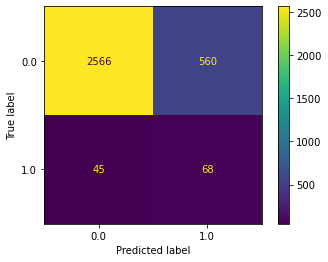

In [16]:

X_pequeñas = df_pequeñas.values[:, :-1] #todas las columnas menos la que hay que predecir
y_pequeñas = df_pequeñas.values[:, -1] 

#hacemos train y test

xtr, xte, ytr, yte = train_test_split(X_pequeñas, y_pequeñas, test_size=0.25, random_state=0, shuffle=True, stratify=y_pequeñas)

model_lgb1 = LGBMClassifier(num_leaves=7, class_weight='balanced', max_depth = 5)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=1)
n_scores = cross_val_score(model_lgb1, xtr, ytr, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

model_lgb1.fit(xtr, ytr)

predicciones_pequeñas = model_lgb1.predict(xte)

from sklearn.metrics import roc_auc_score
mean_accuracy = model_lgb1.score(xte, yte)
auc = roc_auc_score(yte, predicciones_pequeñas)
print('The mean accuracy obtained is: ' + str(mean_accuracy))
print('The area under the ROC curve obtained is: ' + str(auc))

#confusion matrix
metrics.plot_confusion_matrix(model_lgb1,xte, yte)



In [17]:
with open('../modelos/model_pequeñas.pkl', 'wb') as handle:
    pickle.dump(model_lgb1, handle)

<AxesSubplot:>

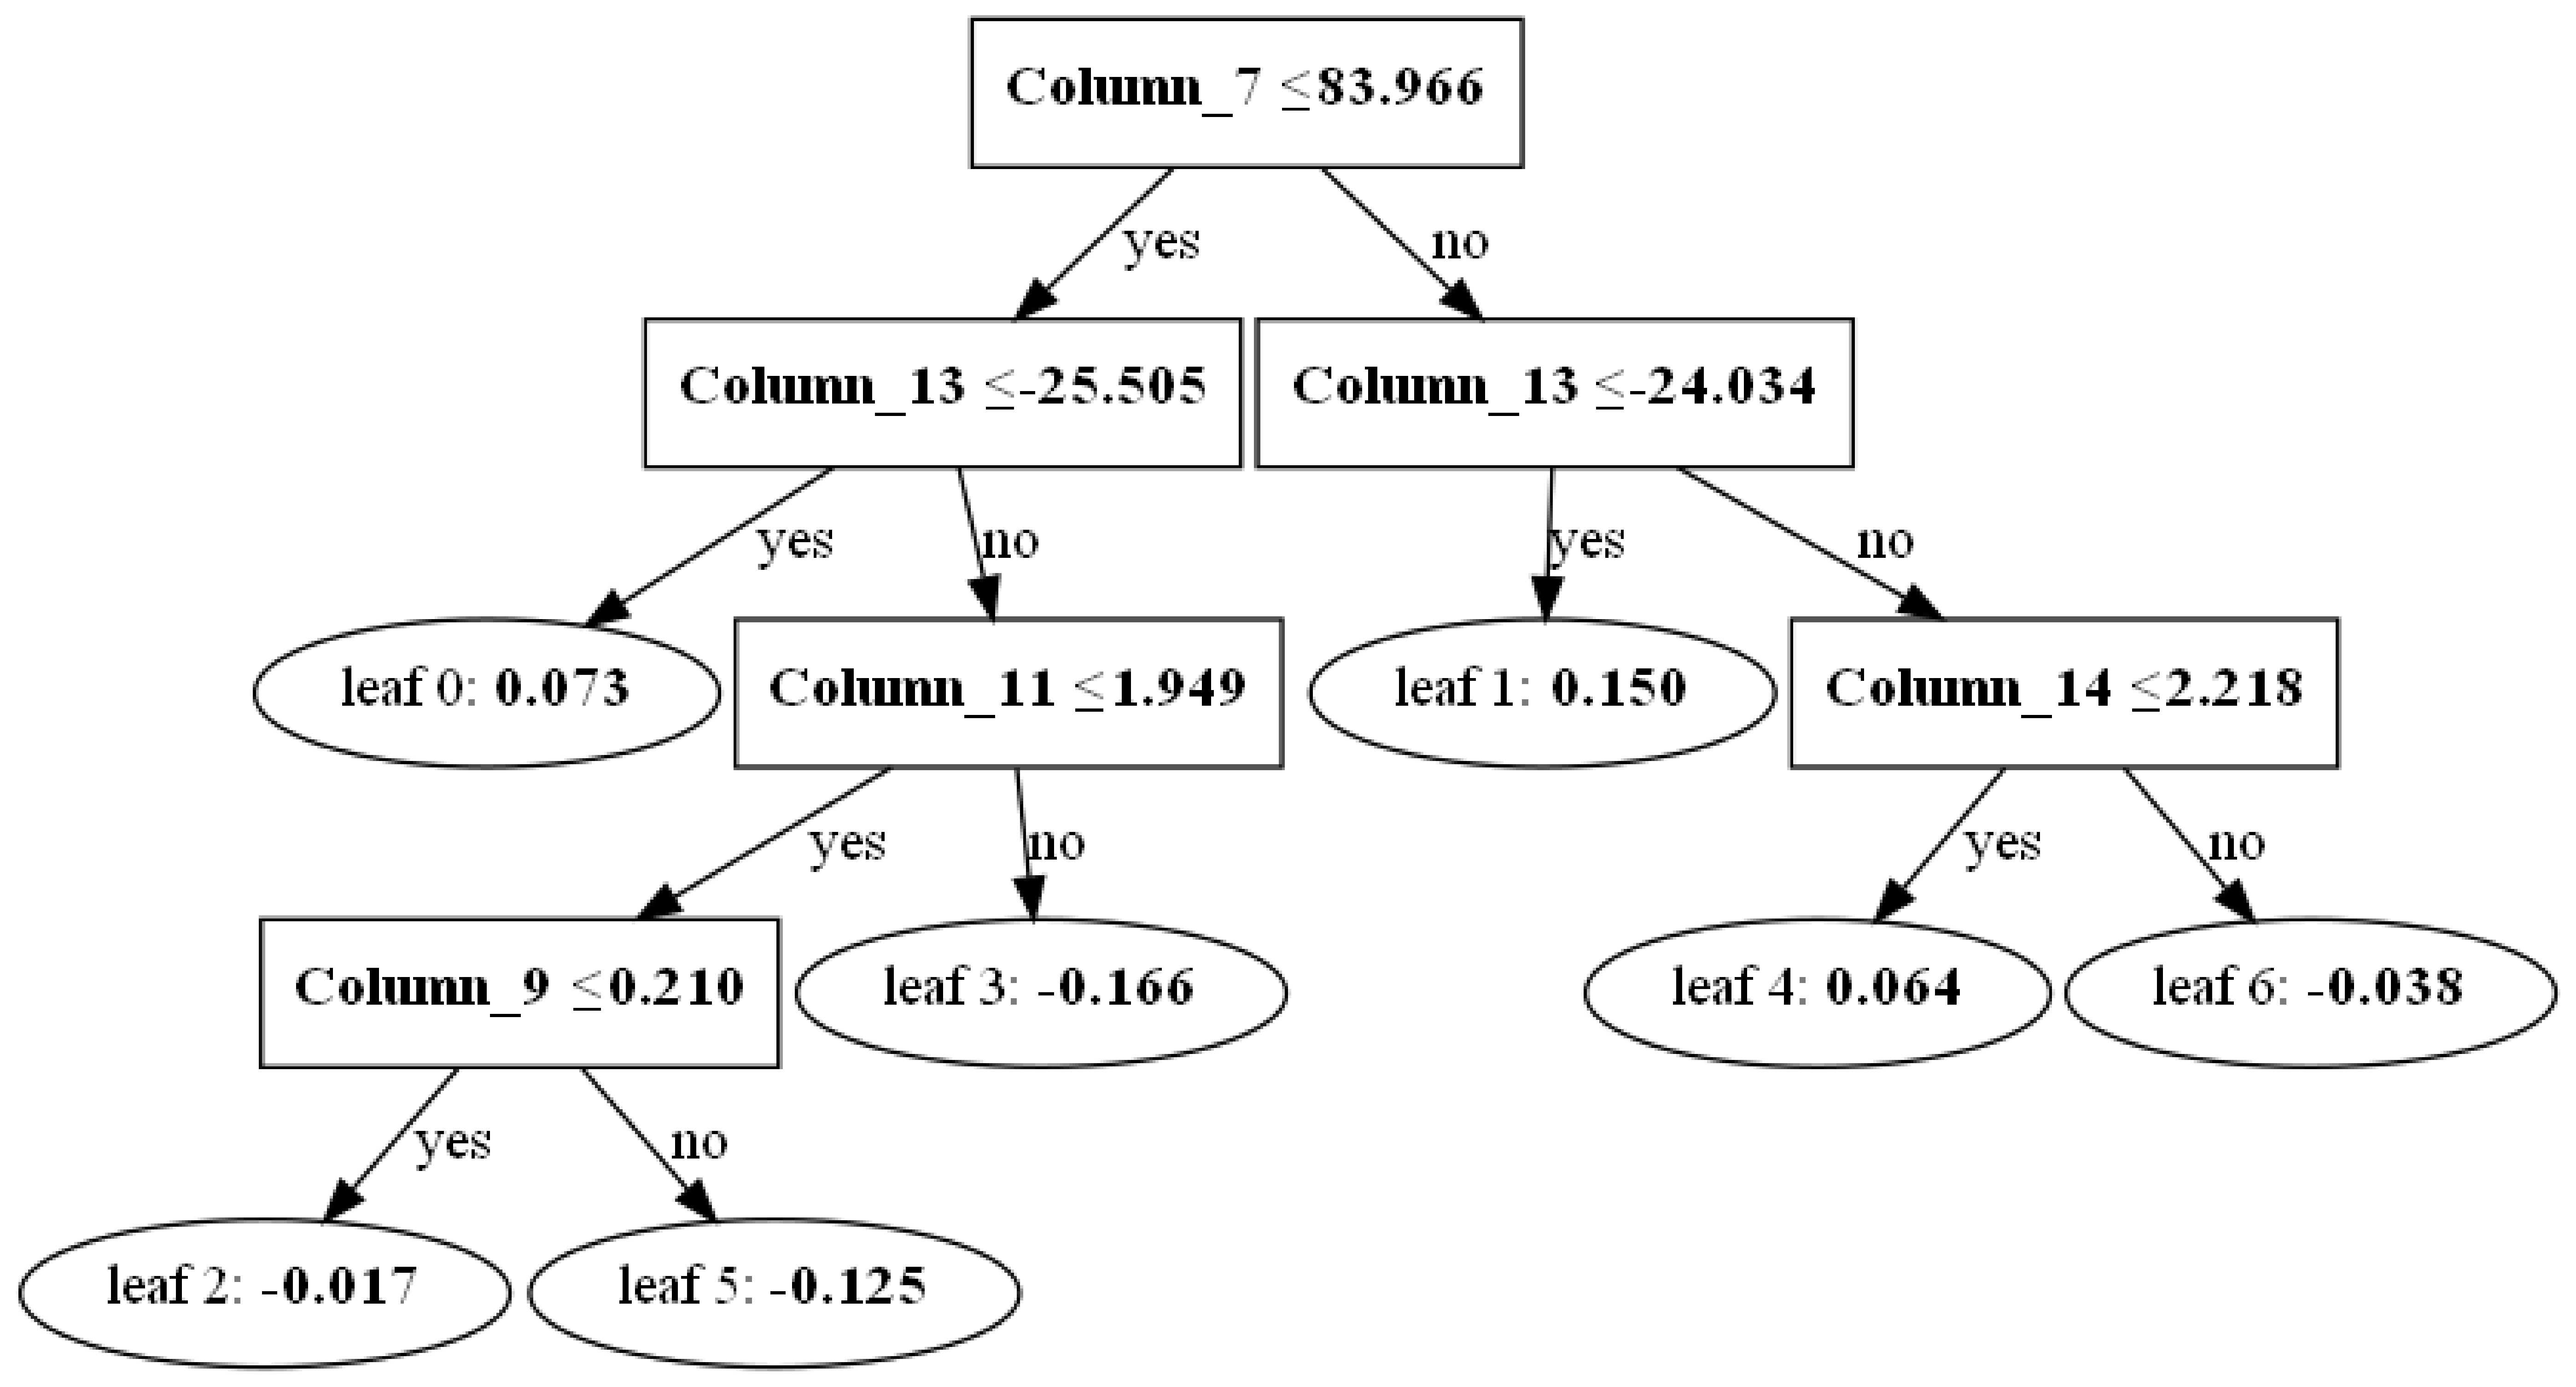

In [18]:
lightgbm.plot_tree(model_lgb1, figsize=(100,100), orientation = 'vertical') 

In [19]:
#Ahora probamos con XGBClassifier
#separamos x y Y

X_pequeñas = df_pequeñas.values[:, :-1] #todas las columnas menos la que hay que predecir
y_pequeñas = df_pequeñas.values[:, -1]  # columna a predecir

print('Statistics original iris data: {}'.format(Counter(y_pequeñas)))
imb_rate = 12503 / 451
print("The imbalance is " + str(imb_rate) + " to 1.")

#corregir el desbalanceo

df_pequeñas.dropna(inplace=True)
X_pequeñas = df_pequeñas.values[:, :-1] 
y_pequeñas = df_pequeñas.values[:, -1]

#hacemos train y test

xtr, xte, ytr, yte = train_test_split(X_pequeñas, y_pequeñas, test_size=0.25, random_state=0, shuffle=True, stratify=y_pequeñas) 
xtr_mix, ytr_mix = SMOTETomek(random_state=seed).fit_resample(xtr, ytr)
X_train_imbcor, y_train_imbcor = SMOTE(random_state=seed).fit_resample(xtr, ytr)


#entrenamos el modelo
model1 = XGBClassifier()
model1_mix = XGBClassifier()
model1_over =XGBClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=1)

n_scores = cross_val_score(model1, xtr, ytr, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
n_scores_mix = cross_val_score(model1_mix, xtr_mix, ytr_mix, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
n_scores_over = cross_val_score(model1_over, X_train_imbcor, y_train_imbcor, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('Accuracy of the balance data: %.3f (%.3f)' % (mean(n_scores_mix), std(n_scores_mix)))
print('Accuracy of the balance data: %.3f (%.3f)' % (mean(n_scores_over), std(n_scores_over)))

# fit the model on the whole dataset

model1.fit(xtr, ytr)
model1_mix.fit(xtr_mix, ytr_mix)
model1_over.fit(X_train_imbcor, y_train_imbcor)

# miramos las predicciones y el accuracy del test

predicciones_pequeñas = model1.predict(xte)
predicciones_pequeñas_mix = model1_mix.predict(xte)
predicciones_pequeñas_over = model1_over.predict(xte)


# comparamos los scores
from sklearn.metrics import roc_auc_score
mean_accuracy = model1.score(xte, yte)
auc = roc_auc_score(yte, predicciones_pequeñas)
print('The mean accuracy obtained is: ' + str(mean_accuracy))
print('The area under the ROC curve obtained is: ' + str(auc))

#
mean_accuracy_mix = model1_mix.score(xte, yte)
auc_mix = roc_auc_score(yte, predicciones_pequeñas_mix)
print('The mean accuracy obtained in the balance data is: ' + str(mean_accuracy_mix))
print('The area under the ROC curve obtained in the balance data is: ' + str(auc_mix))

#
mean_accuracy_over = model1_over.score(xte, yte)
auc_over = roc_auc_score(yte, predicciones_pequeñas_over)
print('The mean accuracy obtained in the balance data by oversampling is: ' + str(mean_accuracy_over))
print('The area under the ROC curve obtained in the balance data by oversampling is: ' + str(auc_over))

#predicciones con los nuevos datos



Statistics original iris data: Counter({0.0: 12503, 1.0: 451})
The imbalance is 27.722838137472284 to 1.
Accuracy: 0.921 (0.034)
Accuracy of the balance data: 0.966 (0.033)
Accuracy of the balance data: 0.963 (0.031)
[14:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\uxuga\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The mean accuracy obtained is: 0.9365079365079365
The area under the ROC curve obtained is: 0.6165254237288136
The mean accuracy obtained in the balance data is: 0.9047619047619048
The area under the ROC curve obtained in the balance data is: 0.5995762711864406
The mean accuracy obtained in the balance data by oversampling is: 0.9365079365079365
The area under the ROC curve obtained in the balance data by oversampling is: 0.733050847457627


In [20]:
#probamos random forest

X_pequeñas = df_pequeñas.values[:, :-1] #todas las columnas menos la que hay que predecir
y_pequeñas = df_pequeñas.values[:, -1]  # columna a predecir

xtr, xte, ytr, yte = train_test_split(X_pequeñas, y_pequeñas, test_size=0.25, random_state=0, shuffle=True, stratify=y_pequeñas) 

forest = RandomForestClassifier(n_estimators=300, random_state=seed, criterion='gini')

forest.fit(xtr, ytr)

predicciones_pequeñas_f = forest.predict(xte)

# comparamos los scores
from sklearn.metrics import roc_auc_score
mean_accuracy = forest.score(xte, yte)
auc = roc_auc_score(yte, predicciones_pequeñas_f)
print('The mean accuracy obtained is: ' + str(mean_accuracy))
print('The area under the ROC curve obtained is: ' + str(auc))


The mean accuracy obtained is: 0.9206349206349206
The area under the ROC curve obtained is: 0.4915254237288136


In [21]:
#como los dos modelos nos dan resultados iguales, por lo que aplicaremos LightGBM que ofrece buenos resultados

Para las empresas medianas utilizaremos LightGBM

Statistics original iris data: Counter({0.0: 3511, 1.0: 395})
The imbalance is 8.888607594936708 to 1.
Accuracy: 0.808 (0.020)
The mean accuracy obtained in the test is: 0.7952917093142272
The area under the ROC curve obtained is: 0.6665343641425647


C:\Users\uxuga\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


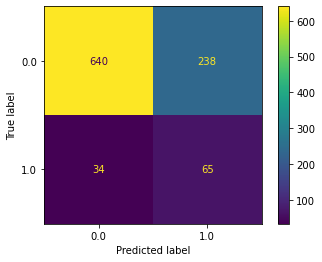

In [22]:
#separamos x y Y

X_medianas = df_medianas.values[:, :-1] #todas las columnas menos la que hay que predecir
y_medianas = df_medianas.values[:, -1]  # columna a predecir

print('Statistics original iris data: {}'.format(Counter(y_medianas)))
imb_rate = 3511 / 395
print("The imbalance is " + str(imb_rate) + " to 1.")

#hacemos train y test

xtr, xte, ytr, yte = train_test_split(X_medianas, y_medianas, test_size=0.25, random_state=0, shuffle=True, stratify=y_medianas) 


# evaluate the model
model2 = LGBMClassifier(num_leaves=10, class_weight='balanced') #balancean los datos

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=1)
n_scores = cross_val_score(model2, xtr, ytr, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# fit the model on the whole dataset

model2.fit(xtr, ytr)

# hacemos predicciones sobre el test y miramos los scores

predicciones_medianas = model2.predict(xte)

from sklearn.metrics import roc_auc_score
mean_accuracy = model2.score(xte, yte)
auc = roc_auc_score(yte, predicciones_medianas)
print('The mean accuracy obtained in the test is: ' + str(mean_accuracy))
print('The area under the ROC curve obtained is: ' + str(auc))

#confusion matrix
metrics.plot_confusion_matrix(model_lgb1,xte, yte)



In [23]:
with open('../modelos/model_medianas.pkl', 'wb') as handle:
    pickle.dump(model2, handle)

In [24]:
import lightgbm
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

<AxesSubplot:>

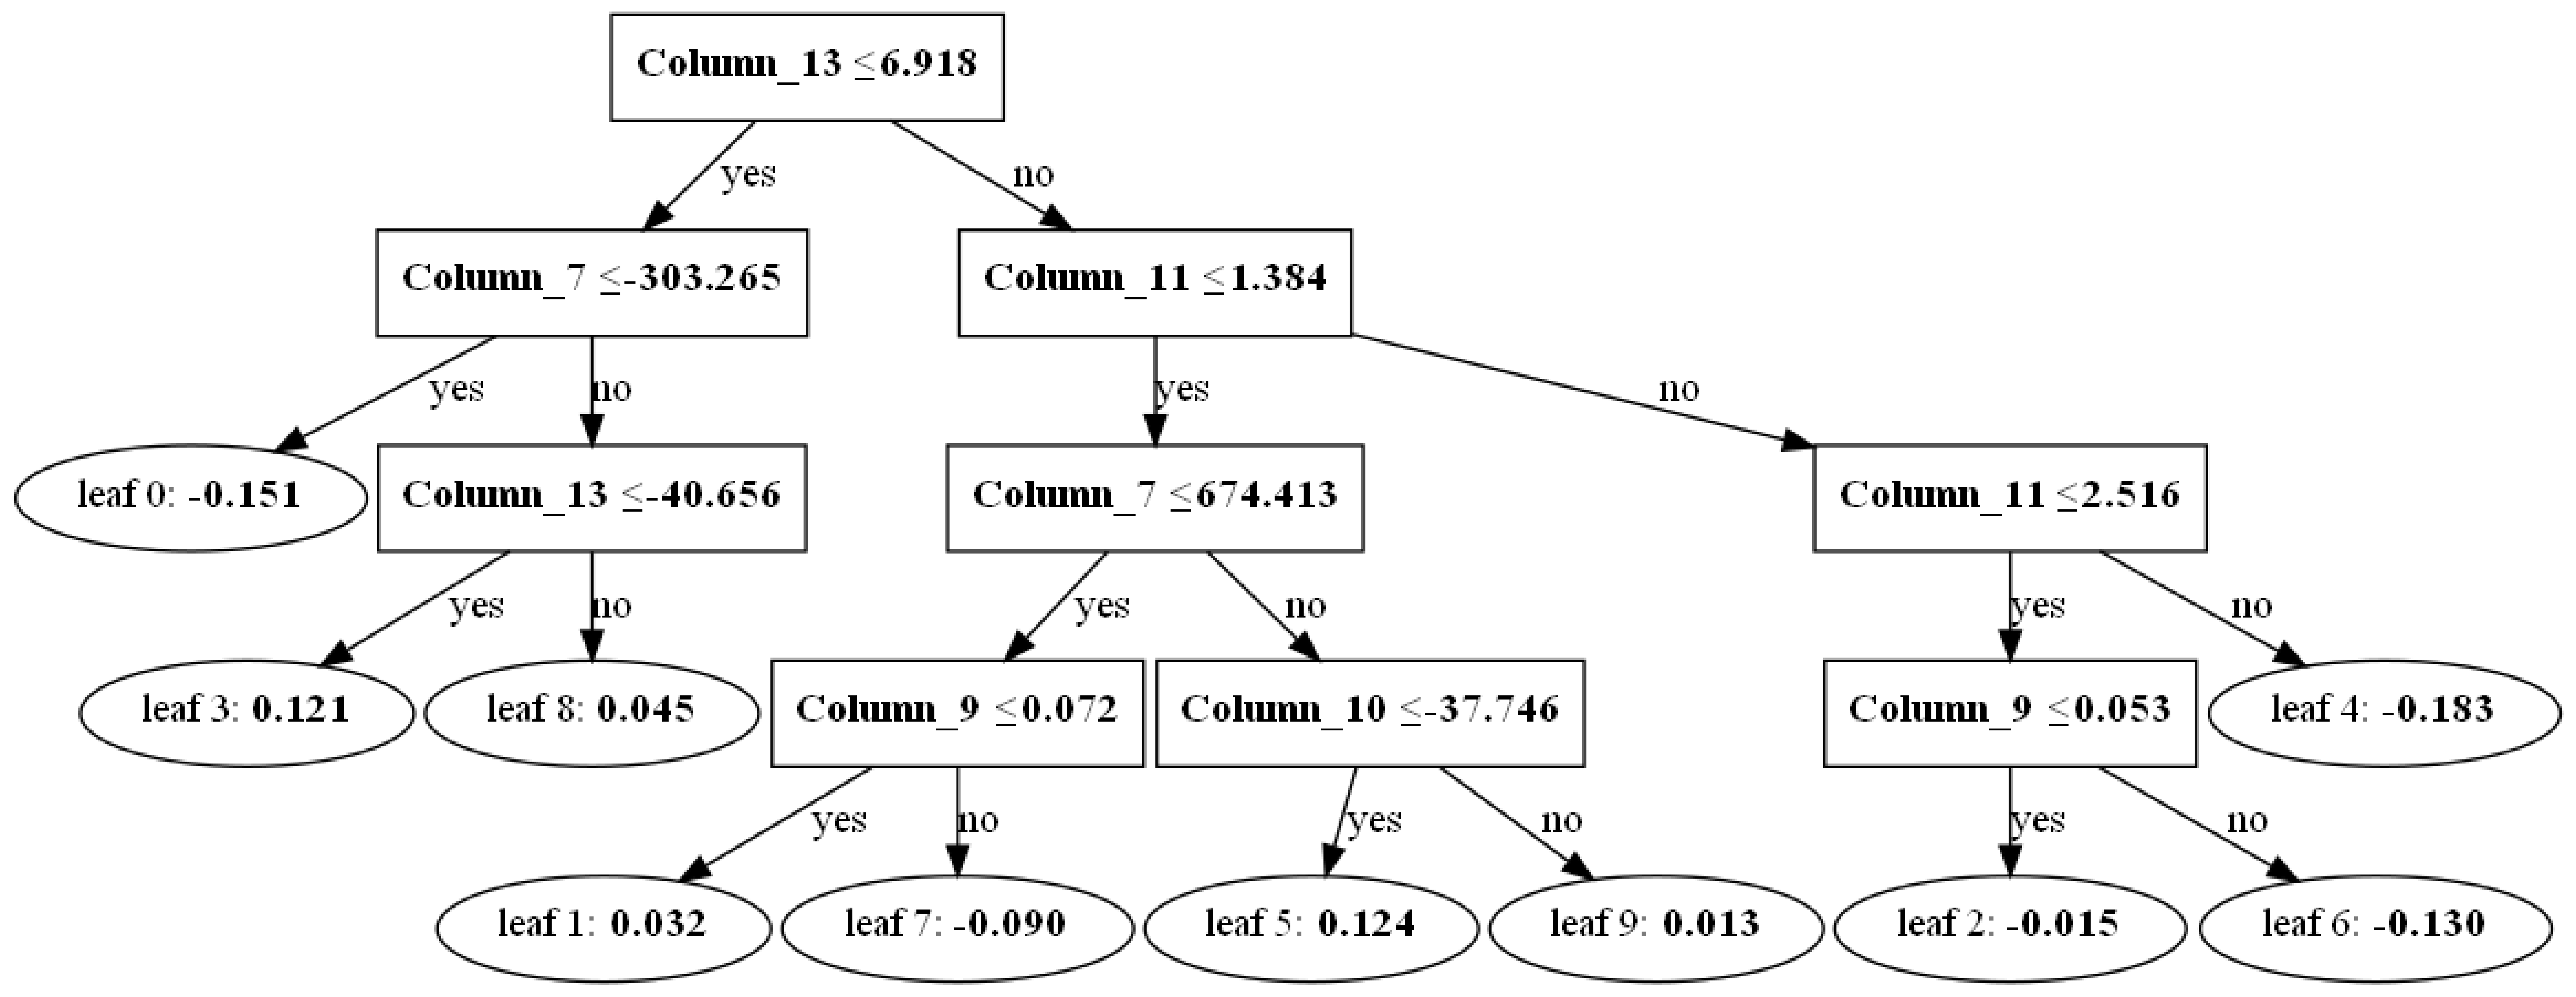

In [25]:
lightgbm.plot_tree(model2, figsize=(100,100), orientation = 'vertical')

Para las empresas grandes utilizaremos regresion logistica

Statistics original data: Counter({0.0: 330, 1.0: 44})
The imbalance is 5.855555555555555 to 1.
The mean accuracy obtained in the test is: 0.7978723404255319
The area under the ROC curve obtained is: 0.5700985761226726
The area under the ROC curve obtained with the threshold change is: 0.5865279299014239


C:\Users\uxuga\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uxuga\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


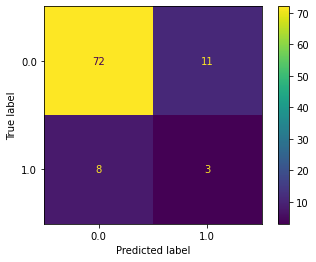

In [26]:
#separamos x y Y

df_grandes.dropna(inplace=True)
X_grandes = df_grandes.values[:, :-1] #todas las columnas menos la que hay que predecir
y_grandes = df_grandes.values[:, -1]  # columna a predecir

print('Statistics original data: {}'.format(Counter(y_grandes)))
imb_rate = 527 / 90
print("The imbalance is " + str(imb_rate) + " to 1.")

#hacemos train y test

xtr, xte, ytr, yte = train_test_split(X_grandes, y_grandes, test_size=0.25, random_state=0, shuffle=True, stratify=y_grandes)

#modelo
logreg = LogisticRegression(penalty='l2', C=1.0, random_state=0)
logreg.fit(xtr,ytr)

#predicciones
y_predic = logreg.predict(xte)
y_pred_prob = logreg.predict_proba(xte)[:, 1]
#y_pred_prob

from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob],threshold=0.3)[0]

from sklearn.metrics import roc_auc_score
mean_accuracy = logreg.score(xte, yte)
auc = roc_auc_score(yte, y_predic)
auc_t = roc_auc_score(yte, y_pred_class)
print('The mean accuracy obtained in the test is: ' + str(mean_accuracy))
print('The area under the ROC curve obtained is: ' + str(auc))
print('The area under the ROC curve obtained with the threshold change is: ' + str(auc_t))

#confusion matrix
metrics.plot_confusion_matrix(logreg,xte, yte)

In [27]:
with open('../modelos/model_grandes.pkl', 'wb') as handle:
    pickle.dump(logreg, handle)

Statistics original data: Counter({0.0: 16455, 1.0: 807})
Accuracy: 0.833 (0.010)
The mean accuracy in the test obtained is: 0.8257645968489342
The area under the ROC curve obtained is: 0.762674663188244


C:\Users\uxuga\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


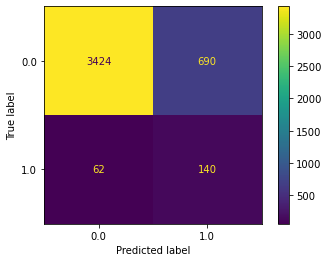

In [28]:
#Ahora haremos con el df general

X_general = df_general.values[:, :-1] #todas las columnas menos la que hay que predecir
y_general = df_general.values[:, -1]  # columna a predecir

print('Statistics original data: {}'.format(Counter(y_general)))
#hacemos train y test

xtr, xte, ytr, yte = train_test_split(X_general, y_general, test_size=0.25, random_state=0, shuffle=True, stratify=y_general)

#modelo
model_general = LGBMClassifier(class_weight='balanced', n_estimators = 100, num_leaves=10)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=1)
n_scores = cross_val_score(model_general, xtr, ytr, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

model_general.fit(xtr,ytr)

#predicciones
y_predic = model_general.predict(xte)

from sklearn.metrics import roc_auc_score
mean_accuracy = model_general.score(xte, yte)
auc = roc_auc_score(yte, y_predic)
print('The mean accuracy in the test obtained is: ' + str(mean_accuracy))
print('The area under the ROC curve obtained is: ' + str(auc))

#confusion matrix
metrics.plot_confusion_matrix(model_general,xte, yte)


<AxesSubplot:>

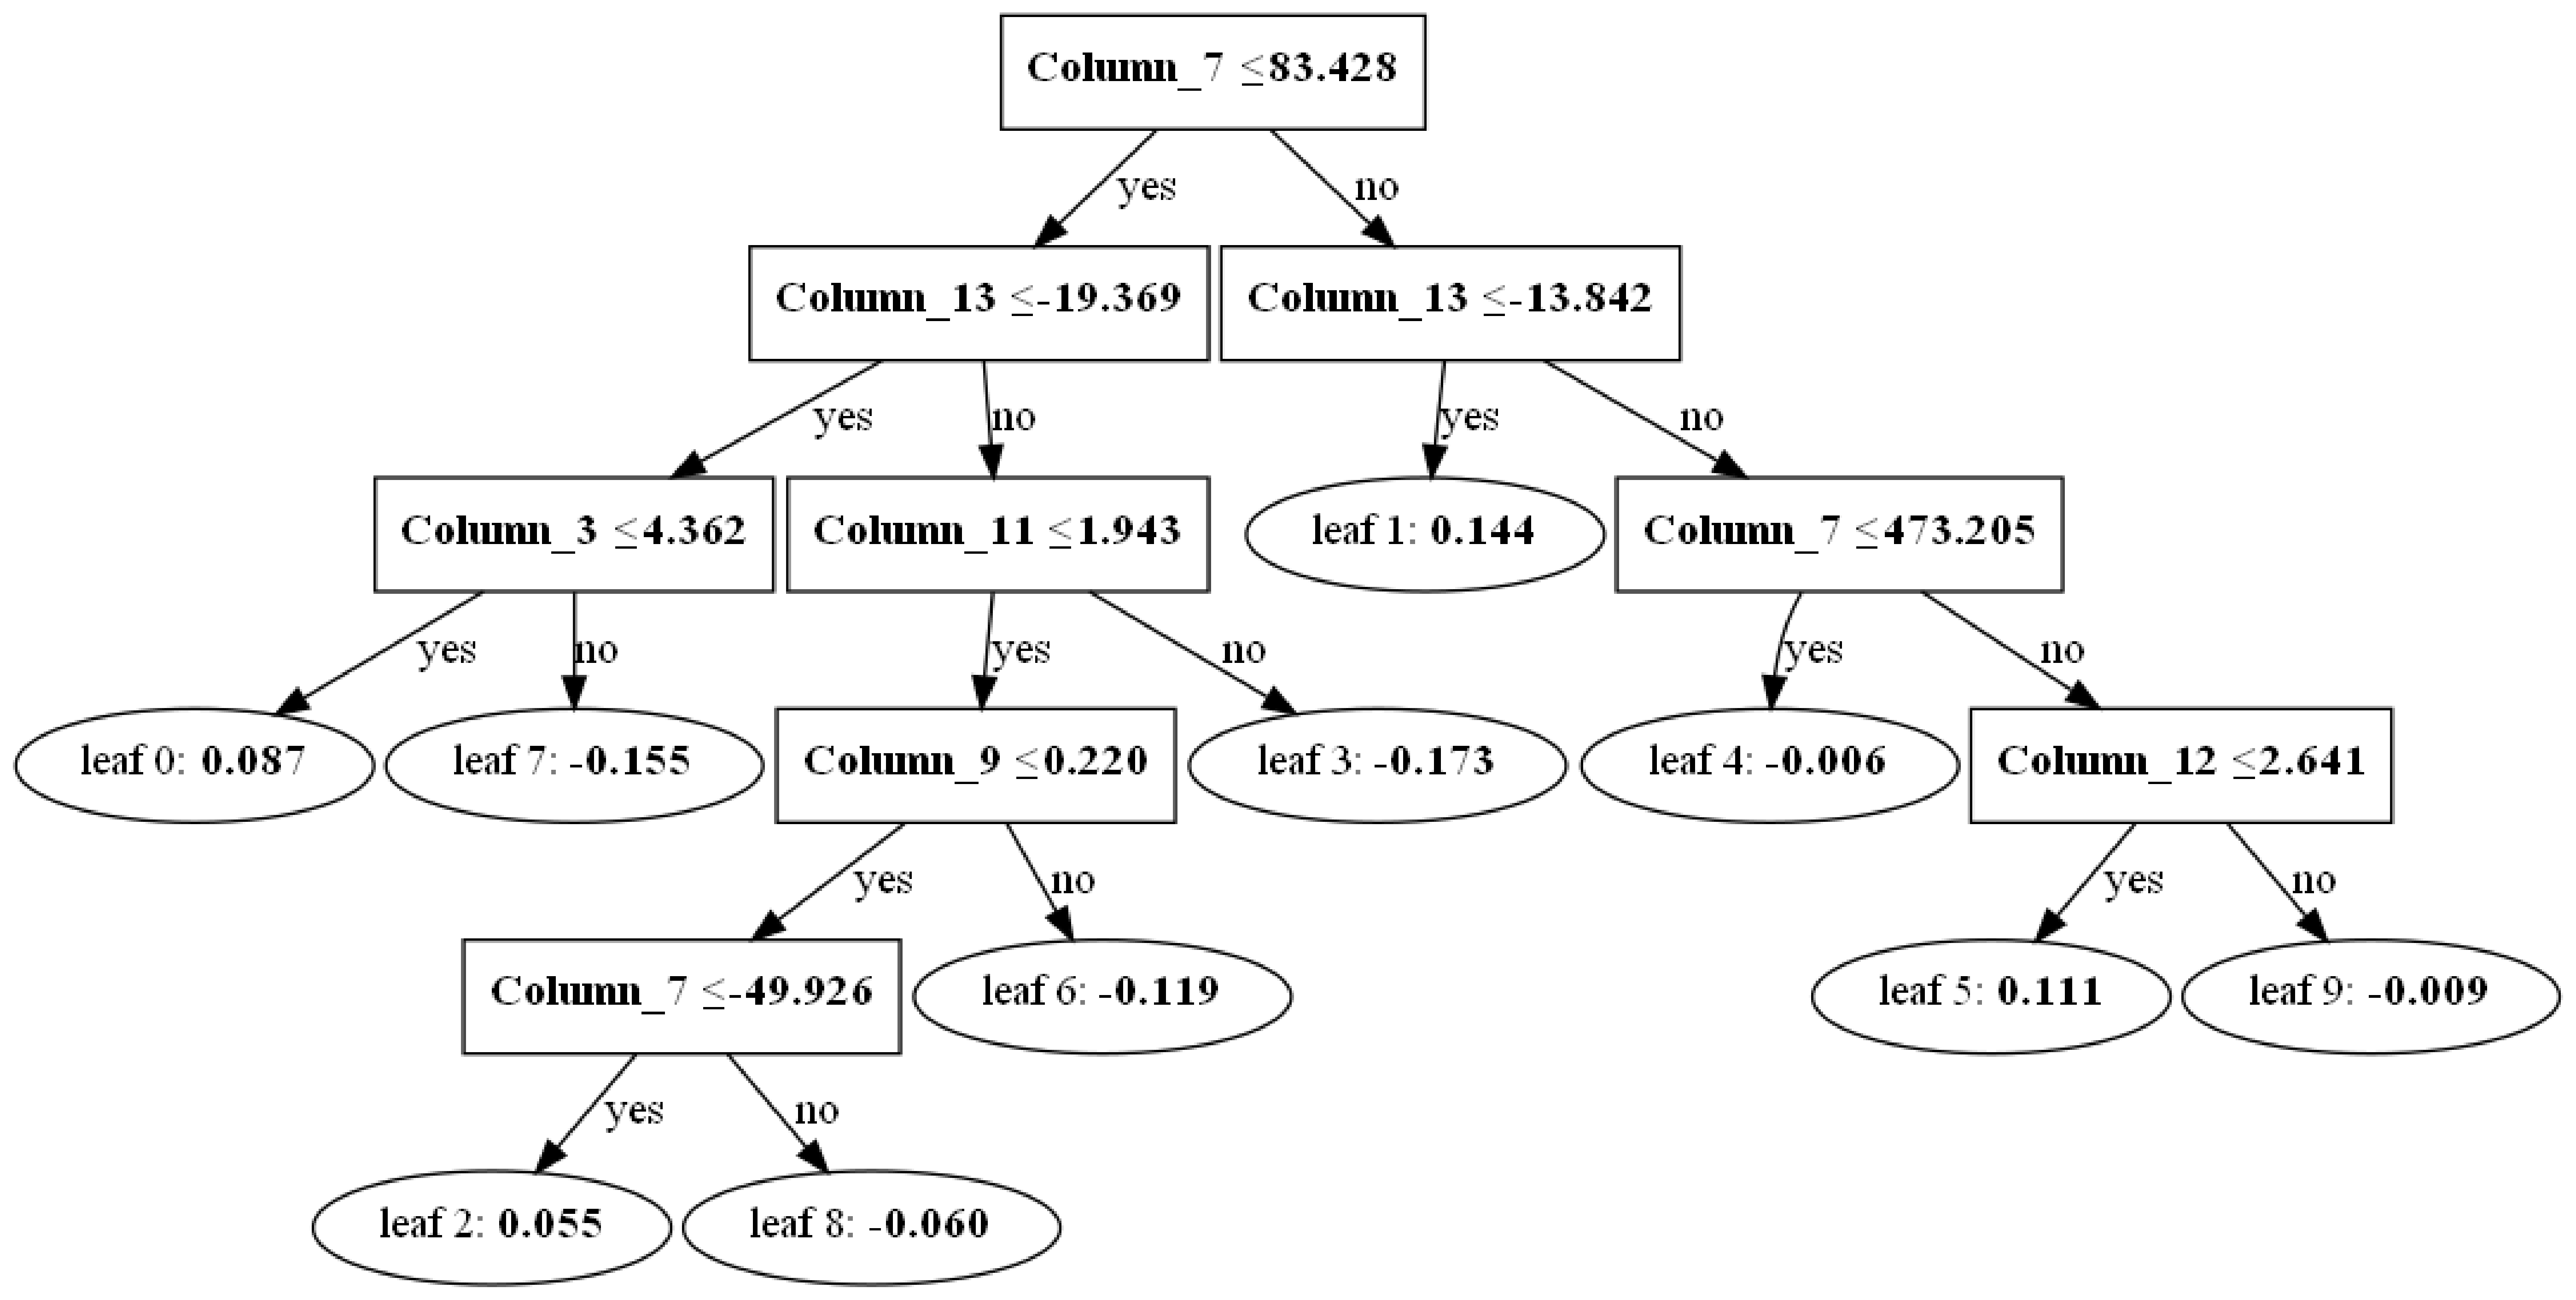

In [29]:
lightgbm.plot_tree(model_general, figsize=(100,100), orientation = 'vertical')

In [30]:
with open('../modelos/model_general.pkl', 'wb') as handle:
    pickle.dump(model_general, handle)

In [31]:
#finalmente utilizamos lightGBM para el sector industrial

In [32]:
df_industria = df_industria.replace(-0, 0)

In [33]:
df_industria

,ratio_endeudamiento_%,ratio_endeudamiento,ratio_liquidez_%,ratio_liquidez,net_debt/ebitda_%,net_debt/ebitda,deuda_neta_%,deuda_neta,ROE_%,ROE,ratio_de_solvencia_percent_%,ratio_de_solvencia_percent,cash_flow_mil_eur_%,cash_flow_mil_eur,tesoreria_mil_eur_%,tesoreria_mil_eur,quiebra_bool
0,0.000000,-3.477364,0.000000,0.915836,0.000000,7.943903,0.000000,6148.49448,0.000000,-1.827522,0.000000,0.712426,0.000000,4472.957060,0.000000,136.91123,1
1,36.512883,0.432942,-28.357619,2.311787,-144.260085,6.799370,-72.593244,-1002.03660,348.589756,-0.118109,-20.306701,3.309779,-148.974955,-145.139179,-80.473274,165.21707,0
2,NaN,307.062495,NaN,0.942065,NaN,-3.056008,NaN,1365.16846,NaN,-38.807286,NaN,1.003257,NaN,-129.796349,NaN,102.25030,1
3,-595.152504,-13.515180,-32.743846,0.765557,-127.978586,-1.639201,42.666327,1792.29973,60548.534745,6.418551,-32.228408,0.926009,-1178.992802,-1281.784849,-83.077762,7.41887,1
4,NaN,-8.162066,NaN,0.493991,NaN,-6.095186,NaN,2018.62368,NaN,1.866958,NaN,0.877482,NaN,-490.838230,NaN,40.22144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423,NaN,0.033925,NaN,32.826034,NaN,-51.784515,NaN,-20309.83500,NaN,0.006897,NaN,30.476715,NaN,384.944000,NaN,7.02100,0
4424,NaN,1.500396,NaN,1.666491,NaN,1.068272,NaN,-66.01011,NaN,-0.936067,NaN,1.666491,NaN,-61.789890,NaN,97.14900,0
4425,45.183886,0.015616,-30.790636,65.036007,-888.245665,14.529622,-7.265392,-8.98105,-112.953216,-0.070272,-30.790636,65.036007,-112.012113,-0.631120,-35.235058,2.77249,0
4426,33.599896,0.690566,-38.788219,1.796347,95.868348,-2.002458,-49.513983,-115.47243,-89.473734,0.102962,-16.579725,2.448087,-79.066895,46.831880,101.141205,95.03226,0


Statistics original data: Counter({0.0: 4126, 1.0: 302})
Accuracy: 0.861 (0.017)
The mean accuracy obtained is: 0.8617886178861789
The area under the ROC curve obtained is: 0.7465891472868217


C:\Users\uxuga\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


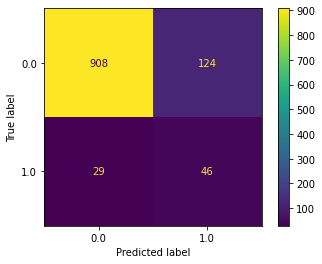

In [34]:


X_industria = df_industria.values[:, :-1] #todas las columnas menos la que hay que predecir
y_industria = df_industria.values[:, -1]  # columna a predecir

print('Statistics original data: {}'.format(Counter(y_industria)))
#hacemos train y test

xtr, xte, ytr, yte = train_test_split(X_industria, y_industria, test_size=0.25, random_state=0, shuffle=True, stratify=y_industria)

#modelo
model_industria = LGBMClassifier(class_weight='balanced', num_leaves=7)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=1)
n_scores = cross_val_score(model_industria, xtr, ytr, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

model_industria.fit(xtr,ytr)

#predicciones
y_predic = model_industria.predict(xte)

from sklearn.metrics import roc_auc_score
mean_accuracy = model_industria.score(xte, yte)
auc = roc_auc_score(yte, y_predic)
print('The mean accuracy obtained is: ' + str(mean_accuracy))
print('The area under the ROC curve obtained is: ' + str(auc))

#confusion matrix
metrics.plot_confusion_matrix(model_industria,xte, yte)



<AxesSubplot:>

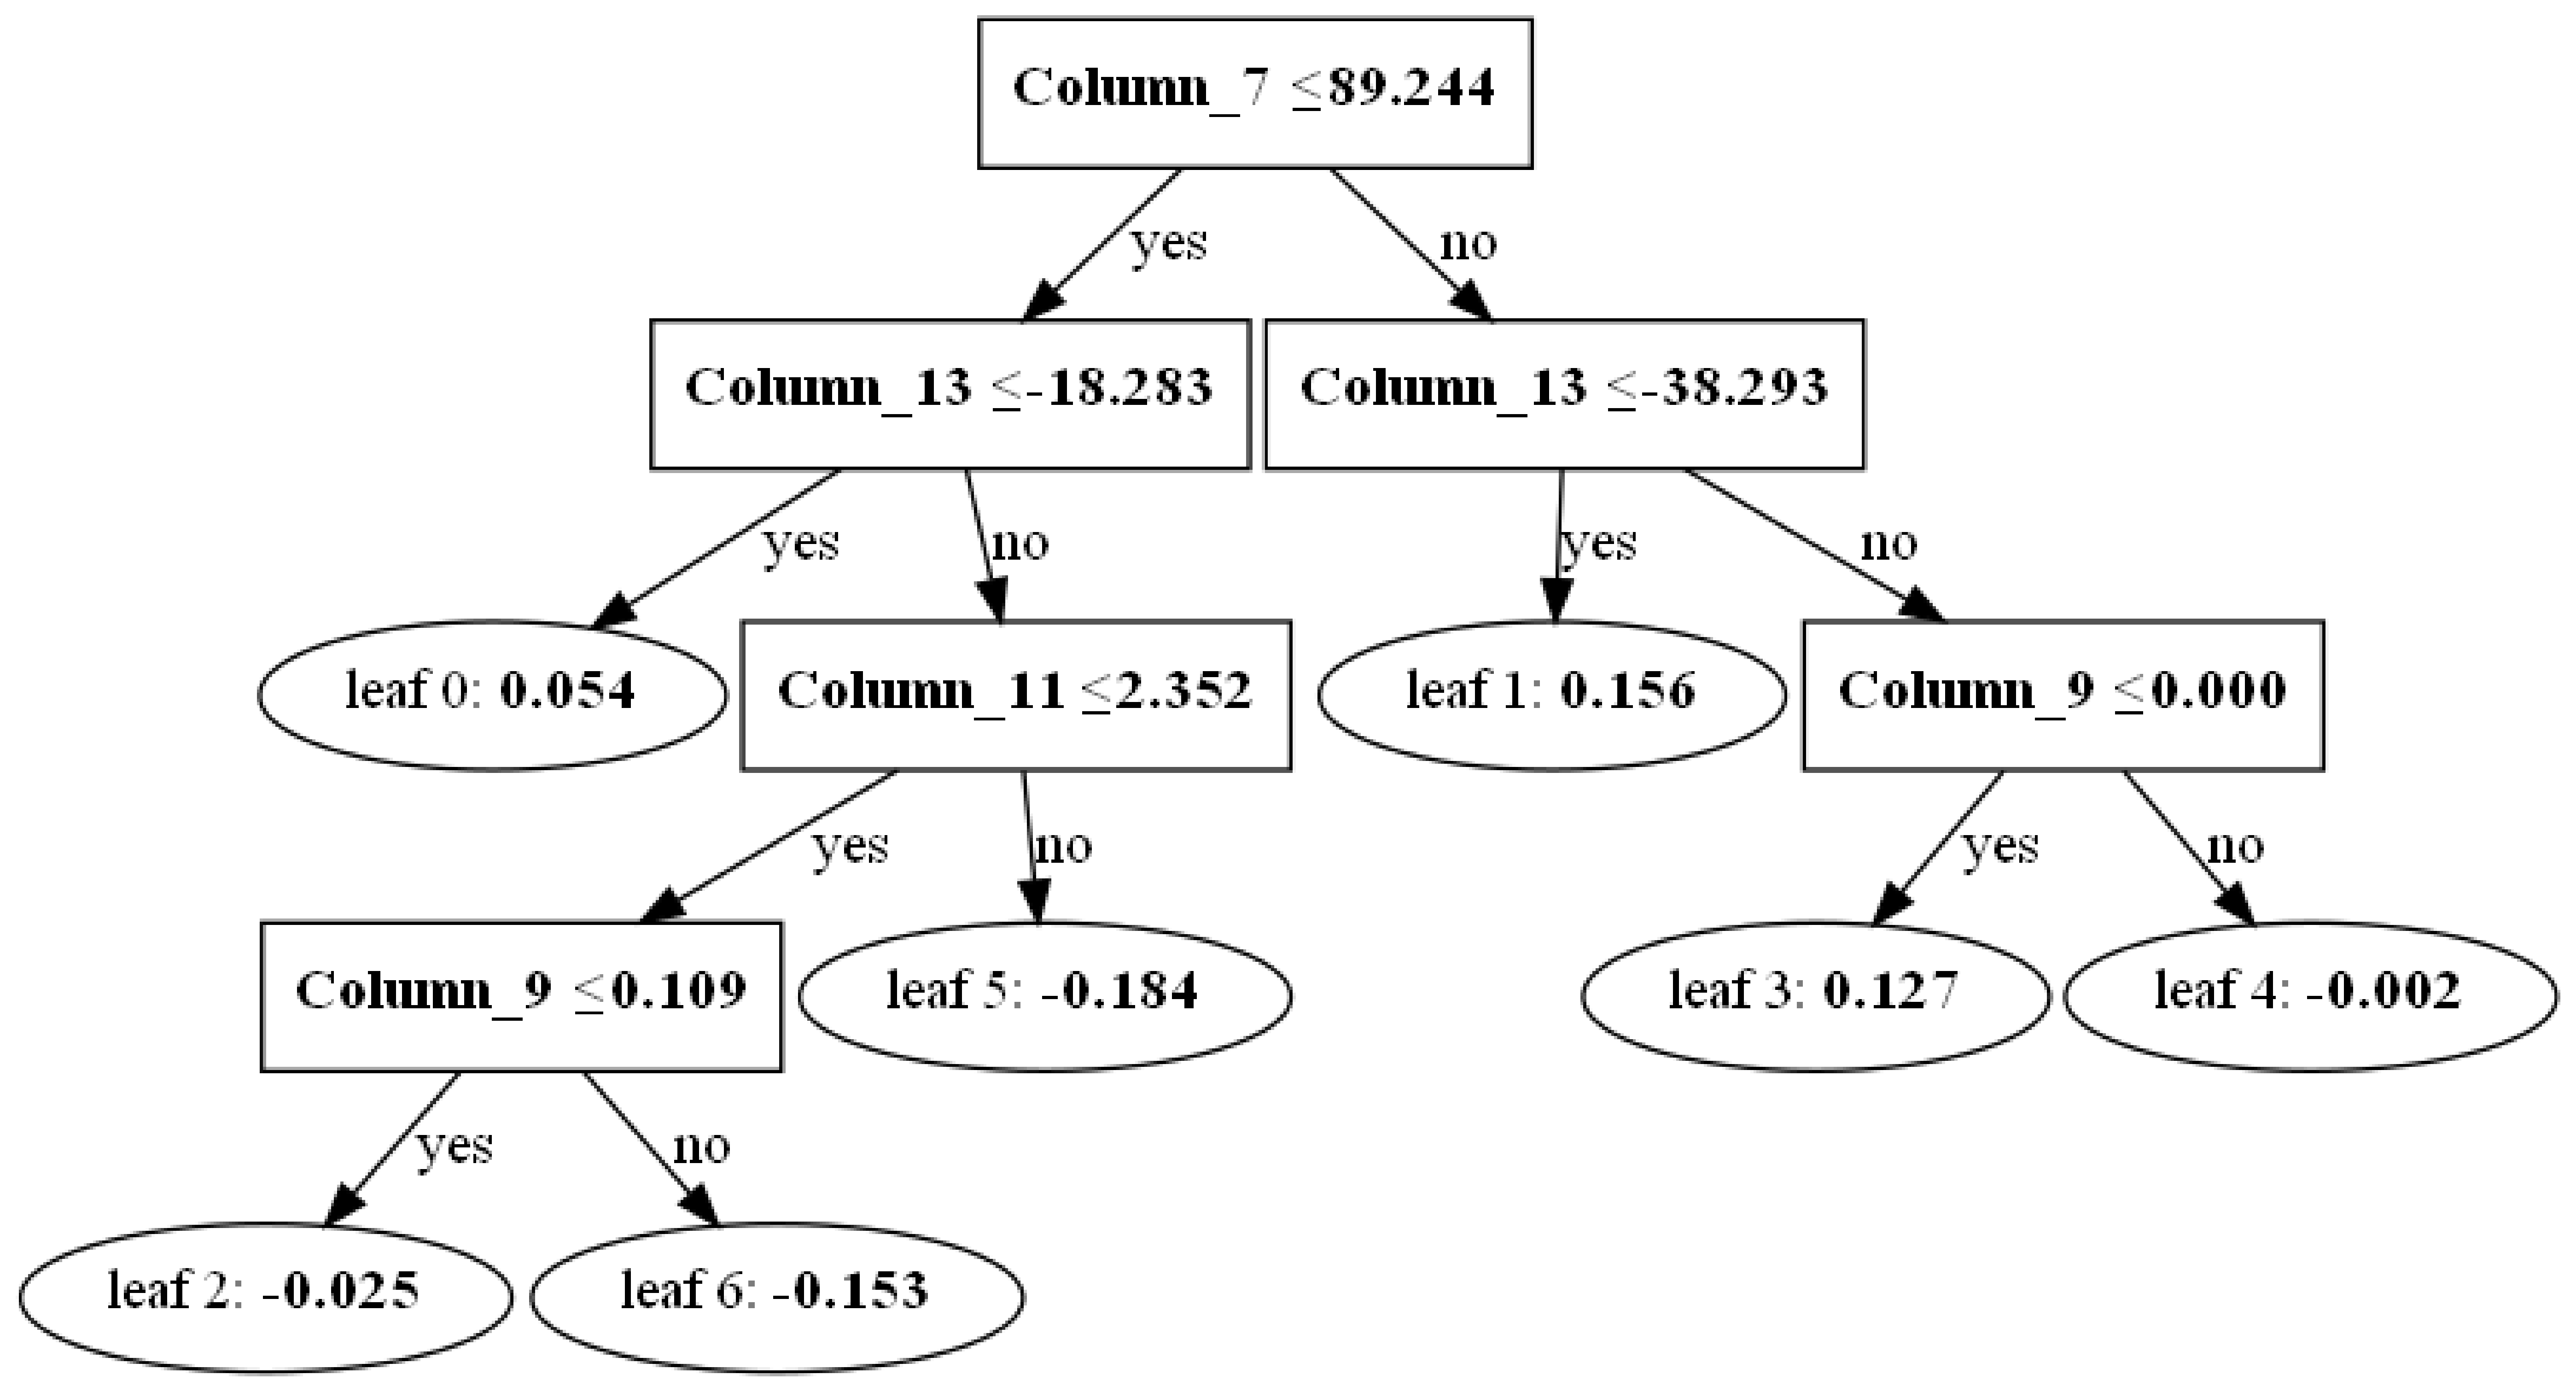

In [35]:
lightgbm.plot_tree(model_industria, figsize=(100,100), orientation = 'vertical')

In [36]:
with open('../modelos/model_sector.pkl', 'wb') as handle:
    pickle.dump(model_industria, handle)

In [38]:
!jupyter nbconvert --to script modelo.ipynb

[NbConvertApp] Converting notebook modelo.ipynb to script
[NbConvertApp] Writing 18443 bytes to modelo.py
